# Using optimization routines from `scipy` and `statsmodels`

In [1]:
%matplotlib inline

In [2]:
import scipy.linalg as la
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
np.set_printoptions(precision=3, suppress=True)

Using `scipy.optimize`
----

One of the most convenient libraries to use is `scipy.optimize`, since it is already part of the Anaconda installation and it has a fairly intuitive interface.

In [35]:
from scipy import optimize as opt

#### Minimizing a univariate function $f: \mathbb{R} \rightarrow \mathbb{R}$

In [36]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

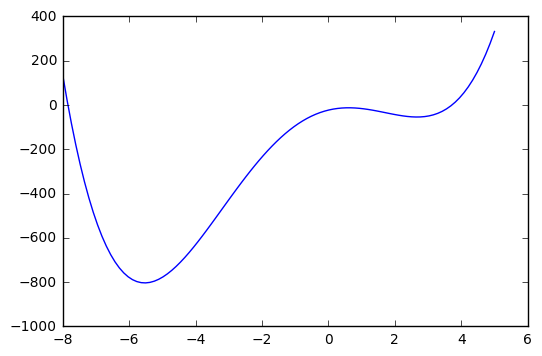

In [37]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

The [`minimize_scalar`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar) function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm, which combines a bracketing strategy with a parabolic approximation.

In [38]:
opt.minimize_scalar(f, method='Brent')

     fun: -803.39553088258845
    nfev: 12
     nit: 11
 success: True
       x: -5.5288011252196627

In [39]:
opt.minimize_scalar(f, method='bounded', bounds=[0, 6])

     fun: -54.210039377127622
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.6688651040396532

### Local and global minima

In [40]:
def f(x, offset):
    return -np.sinc(x-offset)

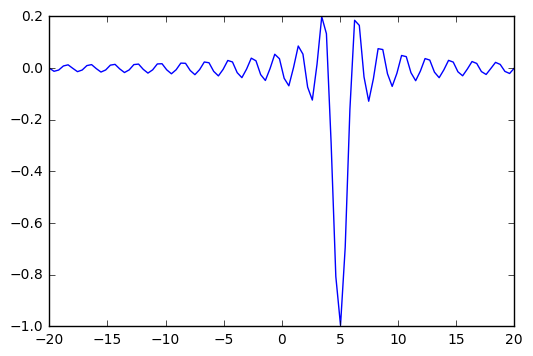

In [41]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [42]:
# note how additional function arguments are passed in
sol = opt.minimize_scalar(f, args=(5,))
sol

     fun: -0.049029624014074166
    nfev: 11
     nit: 10
 success: True
       x: -1.4843871263953001

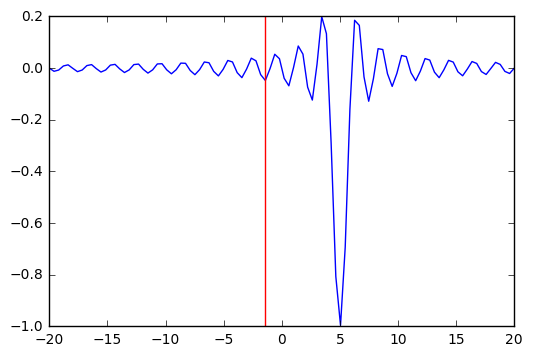

In [43]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red')
pass

#### We can try multiple random starts to find the global minimum

In [44]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [opt.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [45]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]

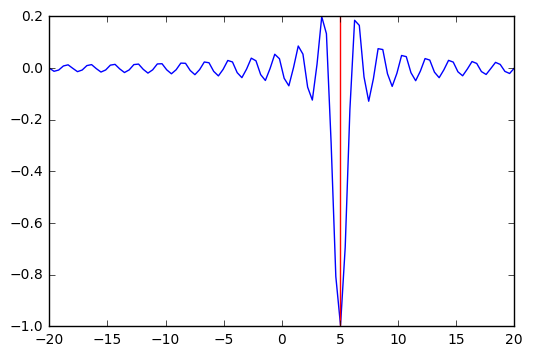

In [46]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

#### Using a stochastic algorithm

See documentation for the [`basinhopping`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.basinhopping.html) algorithm, which also works with multivariate scalar optimization. Note that this is heuristic and not guaranteed to find a global minimum.

In [47]:
from scipy.optimize import basinhopping

x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[ 0.304]])
      jac: array([ 0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 5.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1848
                        nit: 100
                       njev: 616
                          x: array([ 5.])

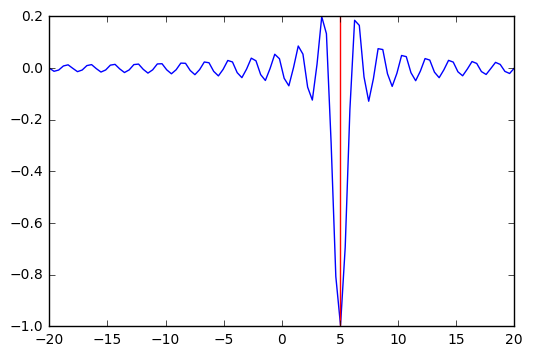

In [48]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

### Constrained optimization with `scipy.optimize`

Many real-world optimization problems have constraints - for example, a set of parameters may have to sum to 1.0 (equality constraint), or some parameters may have to be non-negative (inequality constraint). Sometimes, the constraints can be incorporated into the function to be minimized, for example, the non-negativity constraint $p \gt 0$ can be removed by substituting $p = e^q$ and optimizing for $q$. Using such workarounds, it may be possible to convert a constrained optimization problem into an unconstrained one, and use the methods discussed above to solve the problem.

Alternatively, we can use optimization methods that allow the specification of constraints directly in the problem statement as shown in this section. Internally, constraint violation penalties, barriers and Lagrange multipliers are some of the methods used used to handle these constraints. We use the example provided in the Scipy [tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) to illustrate how to set constraints.

We will optimize:

$$
f(x) = -(2xy + 2x - x^2 -2y^2)
$$
subject to the constraint
$$
x^3 - y = 0 \\
y - (x-1)^4 - 2 \ge 0
$$
and the bounds
$$
0.5 \le x \le 1.5 \\
1.5 \le y \le 2.5
$$

In [83]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

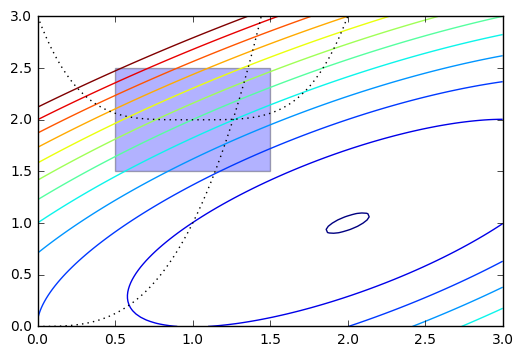

In [84]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3])

To set constraints, we pass in a dictionary with keys `type`, `fun` and `jac`. Note that the inequality constraint assumes a $C_j x \ge 0$ form. As usual, the `jac` is optional and will be numerically estimated if not provided.

In [85]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

In [86]:
x0 = [0, 2.5]

Unconstrained optimization

In [87]:
ux = opt.minimize(f, x0, constraints=None)
ux

      fun: -1.9999999999996365
 hess_inv: array([[ 0.998,  0.501],
       [ 0.501,  0.499]])
      jac: array([ 0., -0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([ 2.,  1.])

Constrained optimization

In [88]:
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

     fun: 2.0499154720910759
     jac: array([-3.487,  5.497,  0.   ])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 1.261,  2.005])

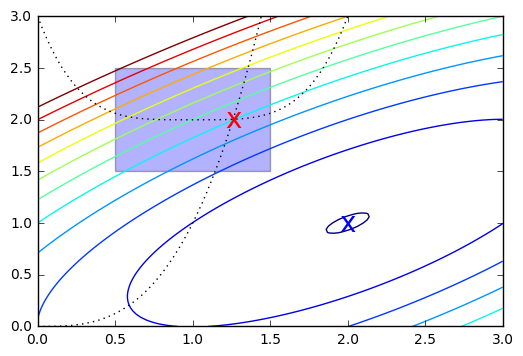

In [89]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);

## Some applications of optimization

### Finding paraemeters for ODE models

This is a specialized application of `curve_fit`, in which the curve to be fitted is defined implicitly by an ordinary differential equation 
$$
\frac{dx}{dt} = -kx
$$
and we want to use observed data to estimate the parameters $k$ and the initial value $x_0$. Of course this can be explicitly solved but the same approach can be used to find multiple parameters for $n$-dimensional systems of ODEs.

[A more elaborate example for fitting a system of ODEs to model the zombie apocalypse](http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html)

In [96]:
from scipy.integrate import odeint

def f(x, t, k):
    """Simple exponential decay."""
    return -k*x

def x(t, k, x0):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(k,))
    return x.ravel()

In [97]:
# True parameter values
x0_ = 10
k_ = 0.1*np.pi

# Some random data genererated from closed form solution plus Gaussian noise
ts = np.sort(np.random.uniform(0, 10, 200))
xs = x0_*np.exp(-k_*ts) + np.random.normal(0,0.1,200)

popt, cov = curve_fit(x, ts, xs)
k_opt, x0_opt = popt

print("k = %g" % k_opt)
print("x0 = %g" % x0_opt)

k = 0.313527
x0 = 9.97788


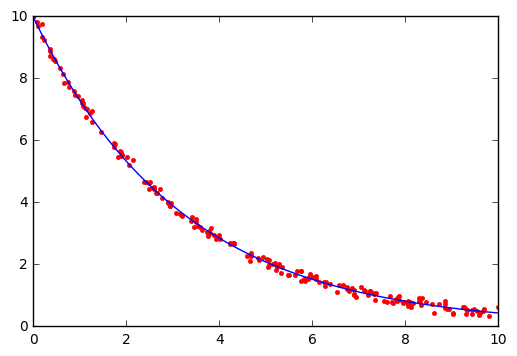

In [98]:
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
plt.plot(ts, xs, 'r.', t, x(t, k_opt, x0_opt), '-');

### Another example of fitting a system of ODEs using the `lmfit` package

You may have to install the [`lmfit`](http://cars9.uchicago.edu/software/python/lmfit/index.html) package using `pip` and restart your kernel. The `lmfit` algorithm is another wrapper around `scipy.optimize.leastsq` but allows for richer model specification and more diagnostics.

In [99]:
! pip install lmfit

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [100]:
from lmfit import minimize, Parameters, Parameter, report_fit
import warnings

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Fit Statistics]]
    # function evals   = 147
    # data points      = 200
    # variables        = 6
    chi-square         = 212.716
    reduced chi-square = 1.096
    Akaike info crit   = 24.328
    Bayesian info crit = 44.118
[[Variables]]
    x0:   1.02060369 +/- 0.181678 (17.80%) (init= 0)
    y0:   1.07048852 +/- 0.110177 (10.29%) (init= 1.997345)
    a:    3.54326836 +/- 0.454087 (12.82%) (init= 2)
    b:    1.21275230 +/- 0.148458 (12.24%) (init= 2)
    c:    0.84528522 +/- 0.079480 (9.40%) (init= 2)
    d:    0.85717177 +/- 0.085645 (9.99%) (init= 2)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      =  0.960 
    C(a, d)                      = -0.956 
    C(b, d)                      = -0.878 
    C(x0, b)                     = -0.759 
    C(x0, a)                     = -0.745 
    C(y0, c)                     = -0.717 
    C(y0, d)                     = -0.682 
    C(c, d)                      =  0.667 
    C(x0, d)                   

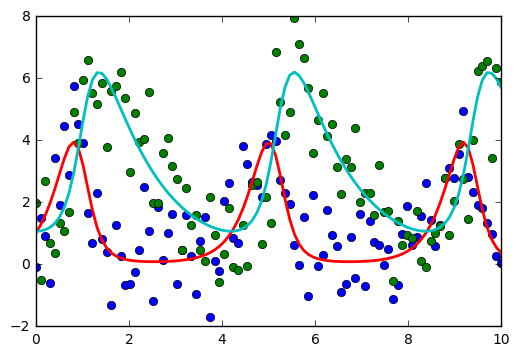

In [101]:
def f(xs, t, ps):
    """Lotka-Volterra predator-prey model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
        c = ps['c'].value
        d = ps['d'].value
    except:
        a, b, c, d = ps
        
    x, y = xs
    return [a*x - b*x*y, c*x*y - d*y]

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value, ps['y0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

t = np.linspace(0, 10, 100)
x0 = np.array([1,1])

a, b, c, d = 3,1,1,1
true_params = np.array((a, b, c, d))

np.random.seed(123)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value= float(data[0, 0]), min=0, max=10)  
params.add('y0', value=float(data[0, 1]), min=0, max=10)  
params.add('a', value=2.0, min=0, max=10)
params.add('b', value=2.0, min=0, max=10)
params.add('c', value=2.0, min=0, max=10)
params.add('d', value=2.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'o')
plt.plot(t, final, '-', linewidth=2);

# display fitted statistics
report_fit(result)

#### Optimization of graph node placement

To show the many different applications of optimization, here is an example using optimization to change the layout of nodes of a graph. We use a physical analogy - nodes are connected by springs, and the springs resist deformation from their natural length $l_{ij}$. Some nodes are pinned to their initial locations while others are free to move. Because the initial configuration of nodes does not have springs at their natural length, there is tension resulting in a high potential energy $U$, given by the physics formula shown below. Optimization finds the configuration of lowest potential energy given that some nodes are fixed (set up as boundary constraints on the positions of the nodes).

$$
U = \frac{1}{2}\sum_{i,j=1}^n ka_{ij}\left(||p_i - p_j||-l_{ij}\right)^2
$$

Note that the ordination algorithm Multi-Dimensional Scaling (MDS) works on a very similar idea - take a high dimensional data set in $\mathbb{R}^n$, and project down to a lower dimension ($\mathbb{R}^k$) such that the sum of distances $d_n(x_i, x_j) - d_k(x_i, x_j)$, where $d_n$ and $d_k$ are some measure of distance between two points $x_i$ and $x_j$ in $n$ and $d$ dimension respectively, is minimized. MDS is often used in exploratory analysis of high-dimensional data to get some intuitive understanding of its "structure".

In [102]:
from scipy.spatial.distance import pdist, squareform

- P0 is the initial location of nodes
- P is the minimal energy location of nodes given constraints
- A is a connectivity matrix - there is a spring between $i$ and $j$ if $A_{ij} = 1$
- $L_{ij}$ is the resting length of the spring connecting $i$ and $j$
- In addition, there are a number of `fixed` nodes whose positions are pinned.

In [103]:
n = 20
k = 1 # spring stiffness
P0 = np.random.uniform(0, 5, (n,2)) 
A = np.ones((n, n))
A[np.tril_indices_from(A)] = 0
L = A.copy()

In [104]:
L.astype('int')

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [105]:
def energy(P):
    P = P.reshape((-1, 2))
    D = squareform(pdist(P))
    return 0.5*(k * A * (D - L)**2).sum()

In [106]:
D0 = squareform(pdist(P0))
E0 = 0.5* k * A * (D0 - L)**2

In [107]:
D0[:5, :5]

array([[ 0.   ,  5.039,  0.921,  1.758,  1.99 ],
       [ 5.039,  0.   ,  5.546,  3.414,  4.965],
       [ 0.921,  5.546,  0.   ,  2.133,  2.888],
       [ 1.758,  3.414,  2.133,  0.   ,  2.762],
       [ 1.99 ,  4.965,  2.888,  2.762,  0.   ]])

In [108]:
E0[:5, :5]

array([[  0.   ,   8.159,   0.003,   0.288,   0.49 ],
       [  0.   ,   0.   ,  10.333,   2.915,   7.862],
       [  0.   ,   0.   ,   0.   ,   0.642,   1.782],
       [  0.   ,   0.   ,   0.   ,   0.   ,   1.552],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ]])

In [109]:
energy(P0.ravel())

In [110]:
# fix the position of the first few nodes just to show constraints
fixed = 4
bounds = (np.repeat(P0[:fixed,:].ravel(), 2).reshape((-1,2)).tolist() + 
          [[None, None]] * (2*(n-fixed)))
bounds[:fixed*2+4]

[[1.191249528562059, 1.191249528562059],
 [4.0389554314507805, 4.0389554314507805],
 [4.474891439430058, 4.474891439430058],
 [0.216114460398234, 0.216114460398234],
 [1.5097341813135952, 1.5097341813135952],
 [4.902910992971438, 4.902910992971438],
 [2.6975241127686767, 2.6975241127686767],
 [3.1315468085492815, 3.1315468085492815],
 [None, None],
 [None, None],
 [None, None],
 [None, None]]

In [111]:
sol = opt.minimize(energy, P0.ravel(), bounds=bounds)

#### Visualization

Original placement is BLUE
Optimized arrangement is RED.

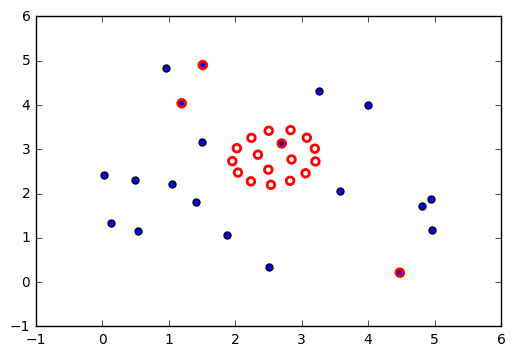

In [112]:
plt.scatter(P0[:, 0], P0[:, 1], s=25)
P = sol.x.reshape((-1,2))
plt.scatter(P[:, 0], P[:, 1], edgecolors='red', facecolors='none', s=30, linewidth=2);

Optimization of standard statistical models
---

When we solve standard statistical problems, an optimization procedure similar to the ones discussed here is performed. For example, consider multivariate logistic regression - typically, a Newton-like algorithm known as iteratively reweighted least squares (IRLS) is used to find the maximum likelihood estimate for the generalized linear model family. However, using one of the multivariate scalar minimization methods shown above will also work, for example, the BFGS minimization algorithm. 

The take home message is that there is nothing magic going on when Python or R fits a statistical model using a formula - all that is happening is that the objective function is set to be the negative of the log likelihood, and the minimum found using some first or second order optimization algorithm.

In [113]:
import statsmodels.api as sm

### Logistic regression as optimization

Suppose we have a binary outcome measure $Y \in {0,1}$ that is conditinal on some input variable (vector) $x \in (-\infty, +\infty)$. Let the conditioanl probability be $p(x) = P(Y=y | X=x)$. Given some data, one simple probability model is $p(x) = \beta_0 + x\cdot\beta$ - i.e. linear regression. This doesn't really work for the obvious reason that $p(x)$ must be between 0 and 1 as $x$ ranges across the real line. One simple way to fix this is to use the transformation $g(x) = \frac{p(x)}{1 - p(x)} = \beta_0 + x.\beta$. Solving for $p$, we get
$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + x\cdot\beta)}}
$$
As you all know very well, this is logistic regression.

Suppose we have $n$ data points $(x_i, y_i)$ where $x_i$ is a vector of features and $y_i$ is an observed class (0 or 1). For each event, we either have "success" ($y = 1$) or "failure" ($Y = 0$), so the likelihood looks like the product of Bernoulli random variables. According to the logistic model, the probability of success is $p(x_i)$ if $y_i = 1$ and $1-p(x_i)$ if $y_i = 0$. So the likelihood is
$$
L(\beta_0, \beta) = \prod_{i=1}^n p(x_i)^y(1-p(x_i))^{1-y}
$$
and the log-likelihood is 
\begin{align}
l(\beta_0, \beta) &= \sum_{i=1}^{n} y_i \log{p(x_i)} + (1-y_i)\log{1-p(x_i)} \\
&= \sum_{i=1}^{n} \log{1-p(x_i)} + \sum_{i=1}^{n} y_i \log{\frac{p(x_i)}{1-p(x_i)}} \\
&= \sum_{i=1}^{n} -\log 1 + e^{\beta_0 + x_i\cdot\beta} + \sum_{i=1}^{n} y_i(\beta_0 + x_i\cdot\beta)
\end{align}

Using the standard 'trick', if we augment the matrix $X$ with a column of 1s, we can write $\beta_0 + x_i\cdot\beta$ as just $X\beta$.

In [114]:
df_ = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
df_.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [115]:
# We will ignore the rank categorical value

cols_to_keep = ['admit', 'gre', 'gpa']
df = df_[cols_to_keep]
df.insert(1, 'dummy', 1)
df.head()

,admit,dummy,gre,gpa
0,0,1,380,3.61
1,1,1,660,3.67
2,1,1,800,4.00
3,1,1,640,3.19
4,0,1,520,2.93


### Solving as a GLM with IRLS

This is very similar to what you would do in R, only using Python's `statsmodels` package. The GLM solver uses a special variant of Newton's method known as iteratively reweighted least squares (IRLS), which will be further desribed in the lecture on multivarite and constrained optimizaiton.

In [116]:
model = sm.GLM.from_formula('admit ~ gre + gpa', 
                            data=df, family=sm.families.Binomial())
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      397
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -240.17
Date:                Thu, 09 Mar 2017   Deviance:                       480.34
Time:                        20:12:11   Pearson chi2:                     398.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.9494      1.075     -4.604      0.000        -7.057    -2.842
gre            0.0027      0.001      2.544      0.011         0.001     0.005
gpa            0.7547      0.320      2.361      0.018         0.128     1.381
==============================================================================
"""

### Or use R

In [117]:
%load_ext rpy2.ipython

In [118]:
%%R -i df
m <- glm(admit ~ gre + gpa, data=df, family="binomial")
summary(m)


Call:
glm(formula = admit ~ gre + gpa, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2730  -0.8988  -0.7206   1.3013   2.0620  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.949378   1.075093  -4.604 4.15e-06 ***
gre          0.002691   0.001057   2.544   0.0109 *  
gpa          0.754687   0.319586   2.361   0.0182 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 480.34  on 397  degrees of freedom
AIC: 486.34

Number of Fisher Scoring iterations: 4



### Home-brew logistic regression using a generic minimization function

This is to show that there is no magic going on - you can write the function to minimize directly from the log-likelihood equation and run a minimizer. It will be more accurate if you also provide the derivative (+/- the Hessian for second order methods), but using just the function and numerical approximations to the derivative will also work. As usual, this is for illustration so you understand what is going on - when there is a library function available, you should probably use that instead.

In [119]:
def f(beta, y, x):
    """Minus log likelihood function for logistic regression."""
    return -((-np.log(1 + np.exp(np.dot(x, beta)))).sum() + (y*(np.dot(x, beta))).sum())

In [120]:
beta0 = np.zeros(3)
opt.minimize(f, beta0, args=(df['admit'], df.ix[:, 'dummy':]), method='BFGS', options={'gtol':1e-2})

      fun: 240.17199087261878
 hess_inv: array([[ 1.115, -0.   , -0.27 ],
       [-0.   ,  0.   , -0.   ],
       [-0.27 , -0.   ,  0.098]])
      jac: array([ 0.   , -0.002, -0.   ])
  message: 'Optimization terminated successfully.'
     nfev: 65
      nit: 8
     njev: 13
   status: 0
  success: True
        x: array([-4.949,  0.003,  0.755])

### Optimization with `sklearn`

There are also many optimization routines in the `scikit-learn` package, as you already know from the previous lectures. Many machine learning problems essentially boil down to the minimization of some appropriate loss function.

### Resources

- [Scipy Optimize reference](http://docs.scipy.org/doc/scipy/reference/optimize.html)
- [Scipy Optimize tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
- [LMFit - a modeling interface for nonlinear least squares problems](http://cars9.uchicago.edu/software/python/lmfit/index.html)
- [CVXpy- a modeling interface for convex optimization problems](https://github.com/cvxgrp/cvxpy)
- [Quasi-Newton methods](http://en.wikipedia.org/wiki/Quasi-Newton_method)
- [Convex optimization book by Boyd & Vandenberghe](http://stanford.edu/~boyd/cvxbook/)
- [Nocedal and Wright textbook](http://www.springer.com/us/book/9780387303031)